In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rakeshkapilavai/extrovert-vs-introvert-behavior-data")

print("Path to dataset files:", path)

/Users/mac/Coding/Extrovert VS Introvert/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 15.0k/15.0k [00:00<00:00, 4.19MB/s]

Extracting files...
Path to dataset files: /Users/mac/.cache/kagglehub/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data/versions/1


In [7]:
import os
import pandas as pd
csv_file="personality_dataset.csv"
data_file_path=os.path.join(path,csv_file)
try:
    df=pd.read_csv(data_file_path)
    print("Data Loaded Successfuly!")
    print(df.head)
except:
    print(f"Error: {csv_filename} not found in {download_path}. Please check the actual file name and path.")

Data Loaded Successfuly!
<bound method NDFrame.head of       Time_spent_Alone Stage_fear  Social_event_attendance  Going_outside  \
0                  4.0         No                      4.0            6.0   
1                  9.0        Yes                      0.0            0.0   
2                  9.0        Yes                      1.0            2.0   
3                  0.0         No                      6.0            7.0   
4                  3.0         No                      9.0            4.0   
...                ...        ...                      ...            ...   
2895               3.0         No                      7.0            6.0   
2896               3.0         No                      8.0            3.0   
2897               4.0        Yes                      1.0            1.0   
2898              11.0        Yes                      1.0            NaN   
2899               3.0         No                      6.0            6.0   

     Drained_after_s

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           2837 non-null   float64
 1   Stage_fear                 2827 non-null   object 
 2   Social_event_attendance    2838 non-null   float64
 3   Going_outside              2834 non-null   float64
 4   Drained_after_socializing  2848 non-null   object 
 5   Friends_circle_size        2823 non-null   float64
 6   Post_frequency             2835 non-null   float64
 7   Personality                2900 non-null   object 
dtypes: float64(5), object(3)
memory usage: 181.4+ KB


In [9]:
df.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,2837.000000,2838.000000,2834.000000,2823.000000,2835.000000
mean,4.505816,3.963354,3.000000,6.268863,3.564727
std,3.479192,2.903827,2.247327,4.289693,2.926582
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,3.000000,1.000000
50%,4.000000,3.000000,3.000000,5.000000,3.000000
75%,8.000000,6.000000,5.000000,10.000000,6.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


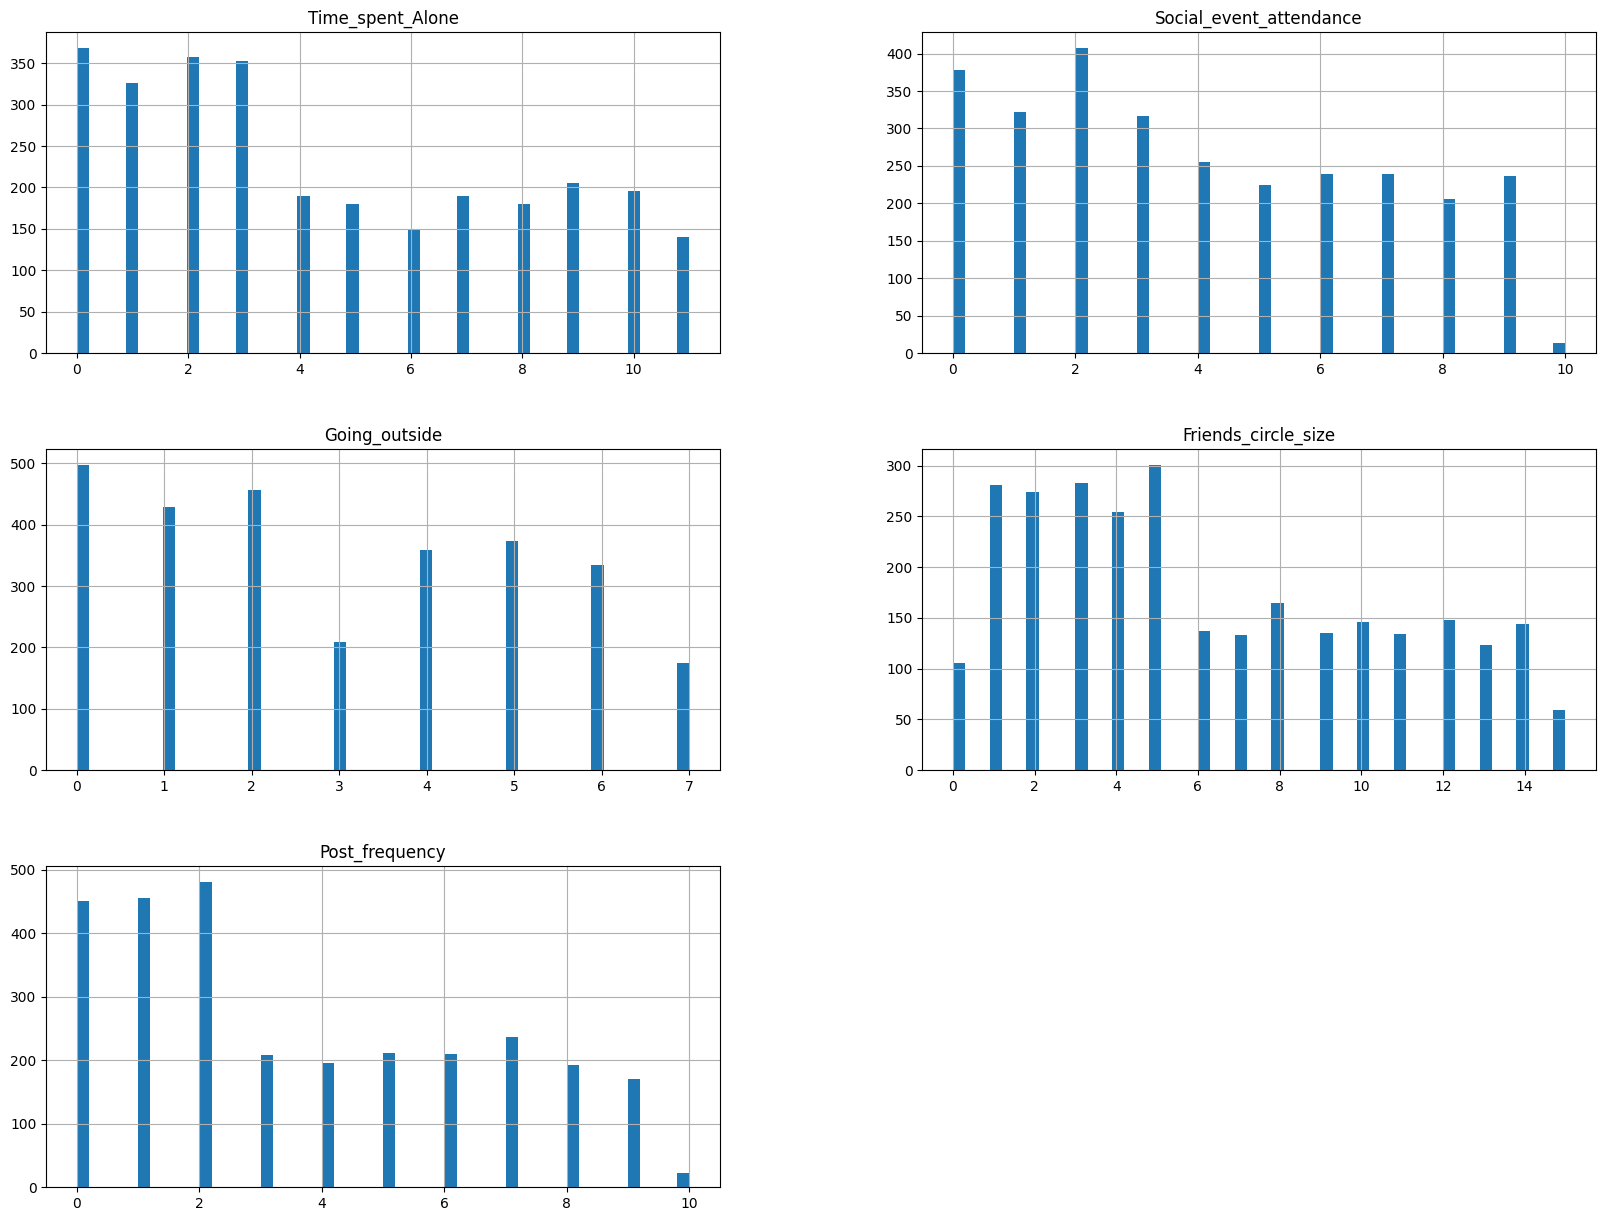

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50,figsize=(20,15))
plt.show()

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(df,df['Personality']):
    strat_train_set=df.loc[train_index]
    strat_test_set=df.loc[test_index]